In [79]:
# Librerias
import os
from bs4 import BeautifulSoup
from unidecode import unidecode
import datetime
import traceback
import json
import csv
import pandas as pd
import jellyfish
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt

In [80]:
# Parámetros
sourceDataFolder = "1-source-data"

bumeraniterationNumber = "4"
bumeranRootPath = sourceDataFolder + r"\main\bumeran\iteration-" + bumeraniterationNumber

linkediniterationNumber = "2"
linkedinRootPath = sourceDataFolder + r"\main\linkedin\iteration-" + linkediniterationNumber

intermFilesFolder = "2-intermediate-files"
mergedMainFolder = "3-results"
logsFolder = "4-logs"

dataVisualizationTopLimit = 20

counterIn = 0
counterOut = 0

In [81]:
# Funciones utilitarias
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def parseLineBreaksAndAccents(text):
  return unidecode(" ".join(text.split()))

def parseNames(text):
  return text.strip().title()

def findTags(tag, color):
  return tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color })

def getChildIndex(mainChildTags, title, color):
  return next((index for index, tag in enumerate(mainChildTags) if ( findTags(tag, color).text == title if findTags(tag, color) else False )), None)

def getSectionsIndexes(mainChildTags, color):
  sectionsIndexes = []
  sectionsTitle = ["Experiencia laboral", "Educación", "Informática", "Idiomas", "Otros Conocimientos"]
  
  for sectionTitle in sectionsTitle:
    sectionIndex = getChildIndex(mainChildTags, sectionTitle, color)
    sectionsIndexes.append(sectionIndex)
  
  sectionsIndexes.append(len(mainChildTags)-1)
  return sectionsIndexes

def getNextSectionIndexValid(sectionsIndexes, i):
  while(not sectionsIndexes[i]):
    i = i + 1

  return sectionsIndexes[i]

def getStartAndEndIndex(sectionsIndexes, i):
  return sectionsIndexes[i], getNextSectionIndexValid(sectionsIndexes, i+1)

def readJson(path, encoding='utf-8', errors=None):
  with open (path, "r", encoding=encoding, errors=errors) as f:
    data = json.loads(f.read())
  return data

def writeJson(data, pathJson, encoding='utf-8'):
  with open(pathJson, 'w', encoding=encoding) as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

def writeCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeTxt(data, pathTxt, encoding='utf-8'):
  with open(pathTxt, 'w', encoding=encoding) as f:
    f.write(data)

In [82]:
# Funciones principales
def getFiles(rootPath, source):
  # Obteniendo todas las carpetas de los perfiles
  folders = [f for f in os.listdir(rootPath) if os.path.isdir(os.path.join(rootPath, f))]

  # Definiendo la lista de archivos final
  files = []

  # Iterando sobre las carpetas
  for folder in folders:
    # Obteniendo los archivos por cada carpeta
    folderFiles = [os.path.join(rootPath, folder, f) for f in os.listdir(os.path.join(rootPath, folder)) if os.path.isfile(os.path.join(rootPath, folder, f))]

    # Agregando esos archivos a la lista de archivos final
    if folderFiles:
      files.extend(folderFiles)

  # Filtros específicos por cada origen
  if source == "bumeran":
    filesFiltered = [f for f in files if ("\Has recibido un CV para el aviso" in f)]
  else:
    filesFiltered = files

  # Filtros para considerar un archivo especifico
  filterIsIn = [
    #r"1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(76).html"
    #r"1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(110).html"
    #r"1-source-data\main\linkedin\iteration-2\bandeja-entrada\New application_ .NET Developer from Cesar Ospino.html"
    #r"1-source-data\main\bumeran\iteration-4\a-considerar\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(1).html"
    #r"1-source-data\main\bumeran\iteration-4\a-considerar\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_.html"
    #r"1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad Sr. (Test Lead)_(1).html"
    #r"1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(1).html"
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Senior_Full Stack_(2).html"
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(6).html"
    #r"1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net Senior_(4).html"
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(24).html"
    # 5 casos con estudios en blanco
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica Jr_(50).html",
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(132).html",
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(173).html",
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(71).html",
    #r"1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(38).html"
  ]
  filesFilteredIsIn = [f for f in filesFiltered if ( f in filterIsIn if filterIsIn else True )]

  # Filtros para omitir un archivo especifico
  filterIsNotIn = [
    # 3 archivos con data incompleta
    r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Senior_Full Stack_(2).html",
    r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(6).html",
    r"1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net Senior_(4).html",
    
  ]
  filesFilteredNotIn = [f for f in filesFilteredIsIn if ( f not in filterIsNotIn if filterIsNotIn else True )]

  # Limites superiores e inferiores en la búsqueda de archivos
  startLimit = None
  topLimit = None
  filesFilteredLimits = filesFilteredNotIn[(startLimit-1 if startLimit else 0): (topLimit if topLimit else len(files))]

  return filesFilteredLimits

In [83]:
def getEncodingBumeran(file, stringLog):
  encoding = "windows-1252"
  try:
    with open(file, "r", encoding="utf-16-le") as f:
      if "charset=unicode" in f.read():
        encoding = 'utf-16-le'
      else:
        raise Exception
  except Exception as e:
    try:
      with open(file, "r", encoding="windows-1252") as f:
        if "charset=windows-1252" in f.read():
          encoding = 'windows-1252'
        else:
          encoding = encoding
    except Exception as e:
      print(file)
      stringLog = stringLog + file + "\n"
      traceback.print_exc()
      stringLog = stringLog + traceback.format_exc() + "\n"
      print()
      stringLog = stringLog + "\n"
      pass
      
  return encoding, stringLog

In [84]:
def getEncodingLinkedin(file, stringLog):
  encoding = "windows-1256"
  try:
    with open(file, "r", encoding="utf-16-le") as f:
      if "charset=unicode" in f.read():
        encoding = 'utf-16-le'
      else:
        raise Exception
  except Exception as e:
    try:
      with open(file, "r", encoding="windows-1256") as f:
        if "charset=windows-1256" in f.read():
          encoding = 'windows-1256'
        else:
          encoding = encoding
    except Exception as e:
      print(file)
      stringLog = stringLog + file + "\n"
      traceback.print_exc()
      stringLog = stringLog + traceback.format_exc() + "\n"
      print()
      stringLog = stringLog + "\n"
      pass
      
  return encoding, stringLog

In [85]:
def getCandidateBumeran(file, encoding, stringLog):
  candidateData = {}
 
  try:
  # Abriendo el archivo
    with open(file, "r", encoding=encoding) as myFile:
      #Parseando el archivo html a soup
      soup = BeautifulSoup(myFile.read(), "lxml")

      # Obteniendo cada uno de los campos para la data

      # Fecha de postulación
      spanDates = soup.find_all("span", {"style": "color:black"})
      if len(spanDates) > 4:
        rawPostulationDate = spanDates[3].text
        postulationDate = datetime.datetime.strptime(spanDates[3].text, "%A, %B %d, %Y %I:%M %p")
      else:
        spanDates2 = soup.find_all("span", {"style": 'font-family:"Calibri",sans-serif;color:black'})
        rawPostulationDate = spanDates2[3].text
        postulationDate = datetime.datetime.strptime(spanDates2[3].text, "%A, %B %d, %Y %I:%M %p")
        
      candidateData["postulationDate"] = postulationDate.strftime("%Y-%m-%d %H:%M")

      # Definiendo los colores a usar para las búsquedas según las fechas
      # En la fecha 2020-06-11 cambio el color de los titulos de cada sección
      inflexionDate = datetime.datetime(2020,6,11,12,5,0)
      colorTitle, colorSections = ("#008599", "#2192C9") if postulationDate <= inflexionDate else ("#E90066", "#0A26EE")

      # Nombre del perfil
      candidateData["profileName"] = parseNames(parseLineBreaksAndAccents(soup.findAll("span", {"style": ("color:" + colorTitle) })[0].text))

      # Nombre del postulante
      rawcandidateName = soup.find_all("ul", {"type": "disc"})[0].find_all("span")[0].text # El split join tambien quita saltos de línea
      candidateData["candidateName"] = parseNames(parseLineBreaksAndAccents(rawcandidateName))

      # Pais de residencia
      tagResidenceCountry = soup.find_all("ul", {"type": "disc"})[0].find_all("span")
      if len(tagResidenceCountry) > 2:
        if tagResidenceCountry[2].text.find(",") != -1:
          residenceCountry = parseNames(parseLineBreaksAndAccents(tagResidenceCountry[2].text[0:tagResidenceCountry[2].text.find(",")]))
          candidateData["residenceCountry"] = residenceCountry
          if residenceCountry == "":
            raise Exception("Error no mapeado 3")
        else:
          raise Exception("Error no mapeado 2")
      else:
        raise Exception("Error no mapeado 1 (posiblemente data incompleta como los 3 casos)")
      
      
      mainDivTag = soup.find_all("div", {"style": 'background-position-x:50%;background-position-y:100%'})[0]
      mainChildTags = mainDivTag.find_all(recursive=False)

      sectionsIndexes = getSectionsIndexes(mainChildTags, colorSections)
      
      # Experiencia laboral
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 0)

      if startIndex and endIndex:
        workExperienceTags = mainChildTags[startIndex+2:endIndex]
        candidateData["lastWorkCenter"] = parseNames(parseLineBreaksAndAccents(workExperienceTags[0].find_all("b")[0].text))
        candidateData["lastWorkPosition"] = parseNames(parseLineBreaksAndAccents(workExperienceTags[1].find_all("b")[0].text))

        daysOfExperience = 0
        for index in range(0, len(workExperienceTags), 2):
          startDate = datetime.datetime.strptime(parseLineBreaksAndAccents(workExperienceTags[index].text)[0: parseLineBreaksAndAccents(workExperienceTags[index].text).find(" - ")] , "%d-%m-%Y")
          endDateText = parseLineBreaksAndAccents(workExperienceTags[index].text)[parseLineBreaksAndAccents(workExperienceTags[index].text).find(" - ")+3: parseLineBreaksAndAccents(workExperienceTags[index].text).find(" | ")]
          endDate = datetime.datetime.strptime(endDateText, "%d-%m-%Y") if endDateText != "Presente" else datetime.datetime.strptime(rawPostulationDate, "%A, %B %d, %Y %I:%M %p")
          daysOfExperience = daysOfExperience + (endDate - startDate).days
        candidateData["yearsOfExperience"] = int(daysOfExperience/365)
        candidateData["worksNumber"] = int(len(workExperienceTags)/2)

        if (candidateData["lastWorkCenter"] == "" or candidateData["lastWorkPosition"] == ""):
          raise Exception("Error no mapeado (experiencia laboral)")
      else:
        raise Exception("561 errores mapeados (experiencia laboral)")
      
      
      # Carrera profesional (última alcanzada)
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 1)

      if startIndex and endIndex:
        educationTags = mainChildTags[startIndex+2:endIndex]
        
        careerTags0 = educationTags[0].find_all("b")
        candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(careerTags0[0].text))
        candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))

        careerTags1 = educationTags[1].find_all("span")
        tempText = careerTags1[len(careerTags1)-2].text
        candidateData["careerStatus"] = parseNames(parseLineBreaksAndAccents(tempText[tempText.find(",")+2:tempText.rfind(",")]))
        candidateData["careerDegree"] = parseNames(parseLineBreaksAndAccents(tempText[tempText.rfind(",")+2:tempText.rfind(".")]))
        candidateData["studiesNumber"] = int(len(educationTags)/2)

        if (candidateData["studyCenter"] == "" or candidateData["careerField"] == "" or candidateData["careerStatus"] == "" or candidateData["careerDegree"] == ""):
          raise Exception("Error no mapeado (educación)")
      else:
        raise Exception("121 errores mapeados (educación)")

      
      # Habilidades técnicas
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 2)

      if startIndex and endIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        technicalSkillsTags = mainChildTags[startIndex+2:endIndex][0].find_all("span")
        candidateData["technicalSkills"] = int(len(technicalSkillsTags)/4)
      else:
        raise Exception("Errores no mapeados (habilidades técnicas)")

      # Lenguajes
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 3)

      if startIndex and endIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        languagesTags = mainChildTags[startIndex+2:endIndex][0].find_all("span")
        candidateData["languages"] = int(len(languagesTags)/7)
      else:
        raise Exception("Errores no mapeados (lenguajes)")

      # Otros conocimientos (habilidades blandas)
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 4)

      if startIndex and endIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        otherKnowledgesTags = mainChildTags[startIndex+2:endIndex][0].find_all("span")
        candidateData["anotherSkills"] = int(len(otherKnowledgesTags)/3)
      else:
        raise Exception("Errores no mapeados (otras habilidades)")

      # Pendiente de analizar casos fraccionarios (se trunco para caso práctico)

      # Salario pretendido
      tagsSalary = [index for index, tag in enumerate(soup.find_all("span")) if "Sueldo pretendido" in tag.text]
      if len(tagsSalary) > 0:
        rawSalary = soup.find_all("span")[tagsSalary[0]+1].text
        candidateData["salary"] = int(rawSalary[rawSalary.find("$")+1:rawSalary.find(".")])
      else:
        raise Exception("Errores no mapeados (salario)")

  except Exception as e:
    candidateData = {}
    #print(file)
    stringLog = stringLog + str(file) + "\n"
    #print(traceback.format_exc())
    stringLog = stringLog + traceback.format_exc() + "\n"
    #print()
    stringLog = stringLog + "\n"
    pass

  return candidateData, stringLog

In [86]:
def getCandidateLinkedin(file, encoding, stringLog):
  candidateData = {}

  try:
  # Abriendo el archivo
    with open(file, "r", encoding=encoding) as myFile:
      #Parseando el archivo html a soup
      
      soup = BeautifulSoup(myFile.read(), "lxml")

      spanBlack = soup.find_all("span", {"style": "color:black"})
      if len(spanBlack) > 4:
        postulationDate = datetime.datetime.strptime(spanBlack[3].text, "%A, %B %d, %Y %I:%M %p")
      else:
        spanBlack2 = soup.find_all("span", {"style": 'font-family:"Calibri",sans-serif;color:black'})
        postulationDate = datetime.datetime.strptime(spanBlack2[3].text, "%A, %B %d, %Y %I:%M %p")

      # Cambiar el lugar de donde se saca, sacarlo del body no del asunto
      if len(spanBlack) > 7:
        rawProfileName = parseLineBreaksAndAccents(spanBlack[7].text)
      else:
        spanBlack2 = soup.find_all("span", {"style": 'font-family:"Calibri",sans-serif;color:black'})
        rawProfileName = parseLineBreaksAndAccents(spanBlack2[7].text)

      startIndexProfileName = rawProfileName.find(": ")
      endIndexProfileName = rawProfileName.find(" from ")

      if postulationDate <= datetime.datetime(2022,9,23,2,15,0):
        
        candidateData["postulationDate"] = postulationDate.strftime("%Y-%m-%d")

        candidateData["profileName"] = parseNames(parseLineBreaksAndAccents(rawProfileName[startIndexProfileName+1:endIndexProfileName]))

        candidateData["candidateName"] = parseNames(parseLineBreaksAndAccents(soup.find("span", {"style": "font-size:10.5pt;color:#262626;text-decoration:none;\n            text-underline:none"}).text))

        tempSpanTags = soup.find_all("span", {"style": 'font-size:9.0pt;font-family:\n            "Helvetica",sans-serif;color:#737373'})
        existsCountry = True if len(tempSpanTags) > 1 else False
        candidateData["residenceCountry"] = parseNames(parseLineBreaksAndAccents(tempSpanTags[len(tempSpanTags)-1].text)) if existsCountry else ""

        candidateData["channel"] = "Linkedin"

        tableTags = soup.find_all("table")

        notHaveScreening = True if "Screening qualifications" not in str(soup) else False
        startTag = 15 if notHaveScreening else 16
        endTag = len(tableTags)-3
        findedTableTags = tableTags[startTag:endTag]

        haveTags = [None, None, None, None, None]

        for index, tag in enumerate(findedTableTags):
          haveTags[0] = index if "Current experience" in tag.text else haveTags[0]
          haveTags[1] = index if "Past experience" in tag.text else haveTags[1]
          haveTags[2] = index if "Education" in tag.text else haveTags[2]
          haveTags[3] = index if "Skills matching your job" in tag.text else haveTags[3]
          haveTags[4] = index if "Highlight" in tag.text else haveTags[4]

        for index, haveTag in enumerate(haveTags):
          if index == 0:
            if haveTag is not None:
              #spanTags = findedTableTags[haveTag].find_all("tr")[1].find_all("span") Caso particular que no vale la pena
              #startSpanIndex = 0 if len(spanTags) == 2 else len(spanTags)-3
              candidateData["lastWorkCenter"] = parseNames(parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].find_all("span")[0].text).split(" at ")[1])
              candidateData["lastWorkPosition"] = parseNames(parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].find_all("span")[0].text).split(" at ")[0])
            else:
              candidateData["lastWorkCenter"] = candidateData["lastWorkPosition"] = ""
          
          elif index == 1:
            if haveTag is not None:
              daysOfExperience = 0
              trTag = findedTableTags[haveTag].find_all("tr")[1]
              pTags = trTag.find_all("p")
              for pTag in pTags:
                spanTag = parseLineBreaksAndAccents(pTag.find_all("span")[1].text)
                startDate = datetime.datetime.strptime(spanTag.split(" - ")[0], "%Y")
                endDate = datetime.datetime.strptime(spanTag.split(" - ")[1], "%Y")
                daysOfExperience = daysOfExperience + (endDate - startDate).days
              candidateData["yearsOfExperience"] = int(daysOfExperience/365)
              candidateData["worksNumber"] = int(len(pTags))
            else:
              candidateData["yearsOfExperience"] = 0
              candidateData["worksNumber"] = 0

          elif index == 2:
            # No se tiene el careerStatus en linkedin
            if haveTag is not None:
              trTags = findedTableTags[haveTag].find_all("tr")[1:]
              #print(trTags[0])
              firstCenterWithDateIndex = -1
              studiesNumber = 0
              for index, trTag in enumerate(trTags):
                if(len(trTag.find_all("span"))>1):
                  if(len(trTags[index-1].find_all("span")) == 1):
                    if firstCenterWithDateIndex == -1:
                      firstCenterWithDateIndex = index-1
                if(len(trTag.find_all("span"))==1):
                  studiesNumber = studiesNumber + 1
              
              #print(firstCenterWithDateIndex)
              #print(trTags[firstCenterWithDateIndex+1].find_all("span")[0].text.split(", ")[1])
              #print(trTags[firstCenterWithDateIndex+1].find_all("span")[0].text.split(", "))
              #print(parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex+1].find_all("span")[0].text.split(", ")[1]))

              if firstCenterWithDateIndex != -1:
                candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex].text))
                tempTagArray = trTags[firstCenterWithDateIndex+1].find_all("span")[0].text.split(",")
                candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex+1].find_all("span")[0].text.split(",")[1])) if len(tempTagArray) > 1 else ""
                candidateData["careerStatus"] = "En Curso" if ("Present" in parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex+1].find_all("span")[1].text)) else "Graduado"
                tempText = parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex+1].find_all("span")[0].text.split(",")[0])
                candidateData["careerDegree"] = parseNames(parseLineBreaksAndAccents(tempText)) if not tempText[0:4].isnumeric() else ""
              else:
                candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(trTags[0].text))
                candidateData["careerField"] = ""
                candidateData["careerStatus"] = ""
                candidateData["careerDegree"] = ""
              
              candidateData["studiesNumber"] = studiesNumber
            else:
              candidateData["studyCenter"] = ""
              candidateData["careerField"] = ""
              candidateData["careerStatus"] = ""
              candidateData["careerDegree"] = ""
              candidateData["studiesNumber"] = 0
          elif index == 3:
            if haveTag is not None:
              skillsCounter = 0
              spanTags = findedTableTags[haveTag].find_all("tr")[1].find_all("span")
              for spanTag in spanTags:
                if "".join(spanTag["style"].split()) == 'font-size:10.5pt;font-family:"Helvetica",sans-serif;mso-fareast-font-family:"TimesNewRoman";color:#4D4D4D':
                  skillsCounter = skillsCounter + 1
              
              candidateData["technicalSkills"] = skillsCounter
            else:
              candidateData["technicalSkills"] = 0
            
            candidateData["languages"] = 1
            candidateData["anotherSkills"] = 0 if notHaveScreening else int(parseLineBreaksAndAccents(soup.find_all("table")[10].text)[parseLineBreaksAndAccents(soup.find_all("table")[10].text).find(": ")+2: parseLineBreaksAndAccents(soup.find_all("table")[10].text).find("/")])
          elif index == 4:
            if haveTag is not None:
              highlightText = parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].text)
              isKnows = True if ("knows" in highlightText) else False
              #print(isKnows)
              isMoreThanTwo = True if ("others" in highlightText) else False
              if isKnows and isMoreThanTwo:
                candidateData["references"] = int(highlightText[highlightText.find(" and ")+5:highlightText.find(" others ")])
              elif isKnows and not isMoreThanTwo:
                candidateData["references"] = int(highlightText.count(" and ") + 1)
              else:
                candidateData["references"] = int(highlightText[highlightText.find(" hired ")+7:highlightText.find(" people ")])
            else:
              candidateData["references"] = 0
        candidateData["salary"] = 0
        
      else:
        candidateData["postulationDate"] = postulationDate.strftime("%Y-%m-%d")

        candidateData["profileName"] = parseNames(parseLineBreaksAndAccents(rawProfileName[startIndexProfileName+1:endIndexProfileName]))

        candidateData["candidateName"] = parseNames(parseLineBreaksAndAccents(soup.find("span", {"style": "color:#0A66C2;text-decoration:none;text-underline:none"}).text))
        
        tempSpanTags = soup.find_all("span", {"style": 'font-size:10.5pt;font-family:"Helvetica",sans-serif;\n          color:#737373'})
        existsCountry = True if len(tempSpanTags) > 1 else False
        candidateData["residenceCountry"] = parseNames(parseLineBreaksAndAccents(tempSpanTags[len(tempSpanTags)-1].text)) if existsCountry else ""

        candidateData["channel"] = "Linkedin"

        tableTags = soup.find_all("table")

        startTag = 14
        endTag = len(tableTags)-3
        findedTableTags = tableTags[startTag:endTag]

        haveTags = [None, None, None, None, None]

        for index, tag in enumerate(findedTableTags):
          haveTags[0] = index if "Current experience" in tag.text else haveTags[0]
          haveTags[1] = index if "Past experience" in tag.text else haveTags[1]
          haveTags[2] = index if "Education" in tag.text else haveTags[2]
          haveTags[3] = index if "Screening qualifications" in tag.text else haveTags[3]
          haveTags[4] = index if "Highlight" in tag.text else haveTags[4]
        
        for index, haveTag in enumerate(haveTags):
          if index == 0:
            if haveTag is not None:
              tempTrTags = parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].find_all("span")[0].text).split(" at ")
              #print(tempTrTags[1].find_all("span")[0].text)
              tempWorkCenter = tempTrTags[1] if len(tempTrTags) > 1 else ""
              candidateData["lastWorkCenter"] = parseNames(parseLineBreaksAndAccents(tempWorkCenter[0:tempWorkCenter.rfind(" - ")-4])) if tempWorkCenter != "" else ""
              candidateData["lastWorkPosition"] = parseNames(parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].find_all("span")[0].text).split(" at ")[0])
            else:
              candidateData["lastWorkCenter"] = candidateData["lastWorkPosition"] = ""
          
          elif index == 1:
            if haveTag is not None:
              daysOfExperience = 0
              trTags = [x for x in findedTableTags[haveTag].find_all("tr") if x.find("span", {"style": 'font-size:9.0pt;font-family:"Helvetica",sans-serif;\n          color:#737373'})]
              #print(trTags)
              for trTag in trTags:
                #print(pTag.text)
                spanTag = parseLineBreaksAndAccents(trTag.find_all("span")[0].text)
                #print(spanTag)
                #print("".isnumeric())
                if spanTag[spanTag.rfind(" - ")-4:spanTag.rfind(" - ")].isnumeric() and spanTag[spanTag.rfind(" - ")+3:spanTag.rfind(" - ")+7].isnumeric():
                  startDate = datetime.datetime.strptime(spanTag[spanTag.rfind(" - ")-4:spanTag.rfind(" - ")], "%Y")
                  endDate = datetime.datetime.strptime(spanTag[spanTag.rfind(" - ")+3:spanTag.rfind(" - ")+7], "%Y")
                  daysOfExperience = daysOfExperience + (endDate - startDate).days
              candidateData["yearsOfExperience"] = int(daysOfExperience/365)
              candidateData["worksNumber"] = int(len(trTags))
            else:
              candidateData["yearsOfExperience"] = 0
              candidateData["worksNumber"] = 0

          elif index == 2:
            # No se tiene el careerStatus en linkedin
            if haveTag is not None:
              trTags = findedTableTags[haveTag].find_all("tr")[1:]
              #print(trTags[0])
              firstCenterWithDateIndex = -1
              studiesNumber = 0
              for index, trTag in enumerate(trTags):
                if " - " in parseLineBreaksAndAccents(trTag.text):
                  if " - " not in parseLineBreaksAndAccents(trTags[index-1].text):
                    if firstCenterWithDateIndex == -1:
                      firstCenterWithDateIndex = index-1
                if(" - " not in parseLineBreaksAndAccents(trTag.text)):
                  studiesNumber = studiesNumber + 1
              #print(firstCenterWithDateIndex)
              if firstCenterWithDateIndex != -1:
                #print("GA")
                candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex].text))
                tempTagArray = parseNames(parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex+1].find("span").text))
                candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(tempTagArray[tempTagArray.find(", ")+1:tempTagArray.rfind(" - ")-4]))
                candidateData["careerStatus"] = "En Curso" if ("Present" in tempTagArray) else "Graduado"
                candidateData["careerDegree"] = parseNames(parseLineBreaksAndAccents(tempTagArray[0:tempTagArray.find(", ")])) if tempTagArray.find(", ") != -1 else ""
                #print(candidateData)
              else:
                candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(trTags[0].text))
                candidateData["careerField"] = ""
                candidateData["careerStatus"] = ""
                candidateData["careerDegree"] = ""
              
              candidateData["studiesNumber"] = studiesNumber
            else:
              candidateData["studyCenter"] = ""
              candidateData["careerField"] = ""
              candidateData["careerStatus"] = ""
              candidateData["careerDegree"] = ""
              candidateData["studiesNumber"] = 0
          
          elif index == 3:
            if haveTag is not None:
              candidateData["technicalSkills"] = 0
              candidateData["languages"] = 1
              candidateData["anotherSkills"] = int(parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].text)[0])
            else:
              candidateData["technicalSkills"] = 0
              candidateData["languages"] = 1
              candidateData["anotherSkills"] = 0
            
          elif index == 4:
            if haveTag is not None:
              highlightText = parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].text)
              #print(highlightText)
              isKnows = True if ("knows" in highlightText) else False
              #print(isKnows)
              isMoreThanTwo = True if ("others" in highlightText) else False
              if isKnows and isMoreThanTwo:
                candidateData["references"] = int(highlightText[highlightText.find(" and ")+5:highlightText.find(" others ")])
              elif isKnows and not isMoreThanTwo:
                candidateData["references"] = int(highlightText.count(" and ") + 1)
              else:
                candidateData["references"] = int(highlightText[highlightText.find(" hired ")+7:highlightText.find(" people ")])
            else:
              candidateData["references"] = 0
        candidateData["salary"] = 0
      
  except Exception as e:
    candidateData = {}
    print(file)
    stringLog = stringLog + str(file) + "\n"
    traceback.print_exc()
    stringLog = stringLog + traceback.format_exc() + "\n"
    print()
    stringLog = stringLog + "\n"
    pass
  
  return candidateData, stringLog

In [87]:
def iterateFiles(files, source):
  # Definiendo el log de errores
  stringLog = ""

  # Definiendo la data final de candidatos
  data = []
  
  # Iterando por cada archivo
  for index, file in enumerate(files):
    if (index % 100 == 0):
      print(str(index) + "/" + str(len(files)) + " archivos analizados")

    # Obteniendo el encoding por cada archivo
    encoding, stringLog = getEncodingBumeran(file, stringLog) if source == 'bumeran' else getEncodingLinkedin(file, stringLog)

    # Obteniendo los datos por cada archivo
    candidate, stringLog = getCandidateBumeran(file, encoding, stringLog) if source == 'bumeran' else getCandidateLinkedin(file, encoding, stringLog)
    
    # Añadiendo los datos del candidato a la data final
    if (candidate):
      data.append(candidate)

  # Realizando un ordenamiento por fecha de postulación, en orden descendente
  sortedData = sorted(data, key=lambda x: (x["postulationDate"]), reverse=True)

  return sortedData, stringLog

In [88]:
def readAndWriteMain(source):
  # Definiendo la carpeta raiz de los archivos a buscar, según el origen
  rootPath = bumeranRootPath if source == "bumeran" else linkedinRootPath

  # Obteniendo la lista de archivos, según el origen
  files = getFiles(rootPath, source)

  # Iterando sobre los archivos, calculando la data y el log de error
  data, stringLog = iterateFiles(files, source)

  # Escribiendo la data de los candidatos (json y csv)
  writeJson(data, os.path.join(intermFilesFolder, source + '.json'))
  writeCsv(data, os.path.join(intermFilesFolder, source + '.csv'))

  # Escribiendo el log de errores
  writeTxt(stringLog, os.path.join(logsFolder, source, datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S") + ".txt"), 'utf-16')

  return data

In [89]:
def readAndWriteMergedMain(mainData):
  mergedMainData = []
  for elem in mainData:
    if (elem):
      mergedMainData.extend(elem)

  writeJson(mergedMainData, os.path.join(mergedMainFolder, "result.json"), 'utf-8')
  writeCsv(mergedMainData, os.path.join(mergedMainFolder, "result.csv"), 'utf-8')

  return mergedMainData

In [90]:
def visualizeData(mergedMainData):
  df = pd.DataFrame(mergedMainData)

  print(df.count())

  columns = [elem for elem in df.columns if elem not in ["postulationDate", "candidateName"]] 

  for column in columns:
    top10 = df[column].value_counts()[:dataVisualizationTopLimit]
    print(top10)
    y_axis = list(reversed(top10.index))
    x_axis = list(reversed(top10.values))
    plt.ylabel(column)
    plt.barh(y_axis, x_axis)
    plt.show()

Inicio: 2023-05-12 02:52:25.440779
Se inició el procesamiento
Se terminó de procesar Bumeran
Se terminó de procesar Linkedin
Se terminó de unir la data principal
postulationDate      6216
profileName          6216
candidateName        6216
residenceCountry     6216
lastWorkCenter       6216
lastWorkPosition     6216
yearsOfExperience    6216
worksNumber          6216
studyCenter          6216
careerField          6216
careerStatus         6216
careerDegree         6216
studiesNumber        6216
technicalSkills      6216
languages            6216
anotherSkills        6216
salary               6216
dtype: int64
Practicante De Recursos Humanos                    360
Gestor De Servicios De Ti                          288
Ejecutivo Comercial                                268
Jefe De Proyecto - Analytics & Ai                  252
Asistente De Recursos Humanos                      228
Analista Programador                               157
Programador .Net                                   14

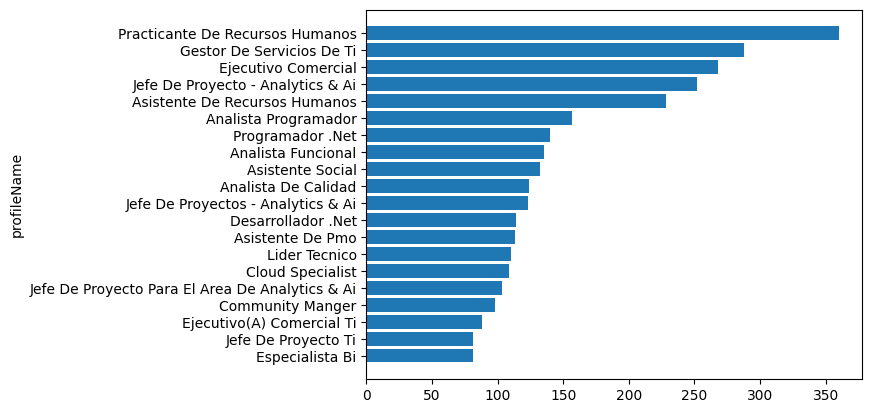

Peru                    6085
Venezuela                109
Argentina                  9
Brasil                     3
Colombia                   3
Ecuador                    2
El Salvador                1
Panama                     1
Republica Dominicana       1
Francia                    1
Bolivia                    1
Name: residenceCountry, dtype: int64


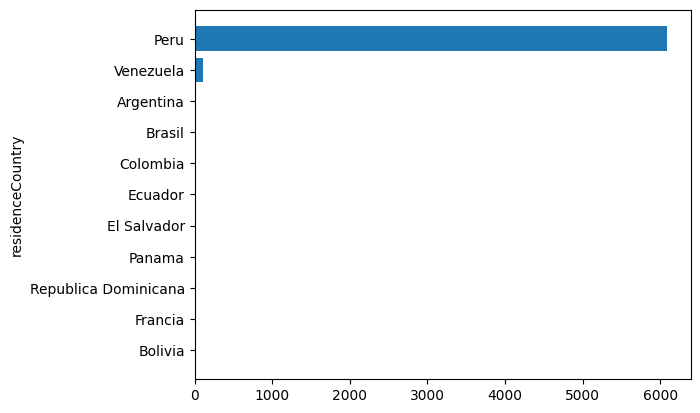

Canvia                                      86
Freelance (Clientes)                        78
Independiente                               42
Global Hitss                                40
Everis                                      39
Indra                                       38
Mdp Consulting                              37
Everis Peru Sac                             29
Tata Consultancy Services                   23
Tivit                                       21
Pontificia Universidad Catolica Del Peru    21
Experis                                     20
Banco De Credito Del Peru                   18
Autoridad Nacional Del Agua                 18
Softtek                                     17
Freelance                                   16
Interbank                                   16
Universidad Privada Del Norte               15
Everis Peru                                 15
Stefanini It Solutions                      15
Name: lastWorkCenter, dtype: int64


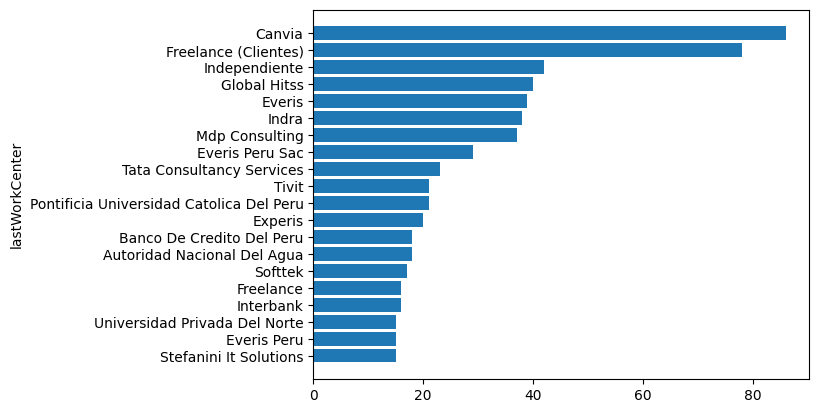

Analista Programador                            235
Analista De Sistemas                            118
Analista Funcional                               80
Supervisor De Infraestructura De Redes Cisco     78
Jefe De Proyectos                                61
Project Manager                                  52
Analista                                         39
Trabajadora Social                               35
Jefe De Sistemas                                 30
Asistente Administrativo                         28
Ejecutivo Comercial                              27
Practicante                                      26
Asistente De Sistemas                            26
Data Engineer                                    26
Asistente De Recursos Humanos                    26
Analista Qa                                      25
Key Account Manager                              25
Asesor Comercial                                 23
Analista Desarrollador                           23
Analista Pro

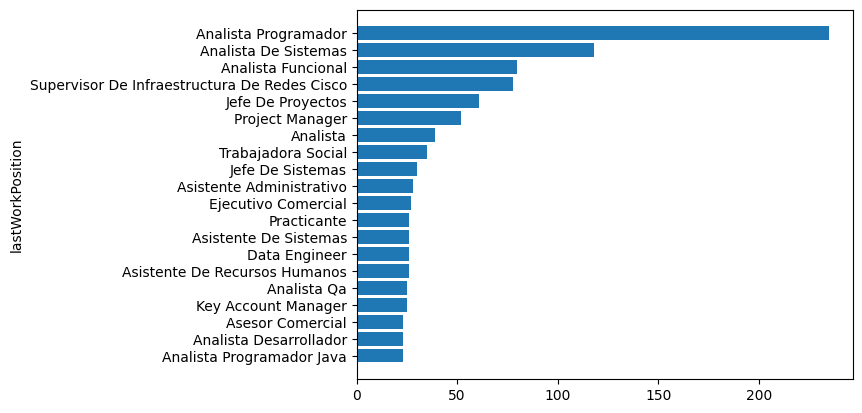

5     490
4     475
8     456
6     450
7     418
2     374
9     373
3     357
10    351
1     315
11    291
0     246
13    215
12    210
15    202
14    179
16    129
17     97
18     89
19     84
Name: yearsOfExperience, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_7956\1267574479.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


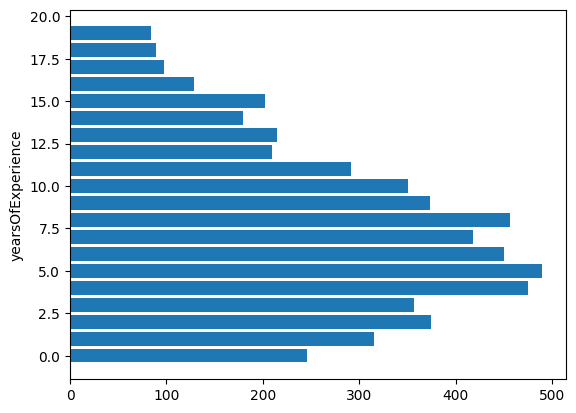

5     855
6     769
4     752
7     674
3     546
8     512
9     385
2     369
10    322
1     222
11    207
12    202
13    118
14    105
15     61
17     29
16     28
18     17
19     12
21      8
Name: worksNumber, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_7956\1267574479.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


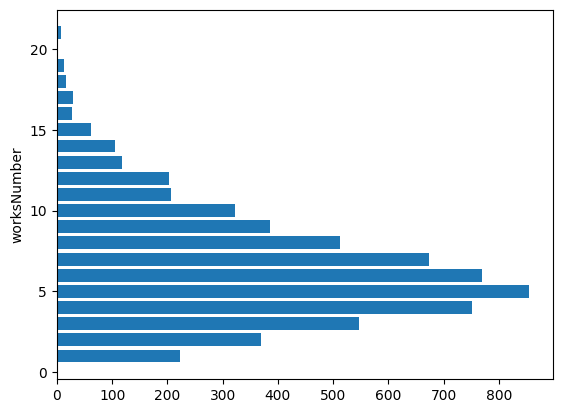

Universidad Peruana De Ciencias Aplicadas    347
Universidad Tecnologica Del Peru             215
Pontificia Universidad Catolica Del Peru     212
Universidad Nacional Mayor De San Marcos     176
Universidad Esan                             172
Universidad Privada Del Norte                147
Upc                                          137
Universidad Nacional De Ingenieria           132
Cibertec                                     129
Universidad Ricardo Palma                    124
Universidad De Lima                          116
Universidad Cesar Vallejo                    115
Instituto Cibertec                           111
Universidad Nacional Federico Villarreal     109
Universidad De San Martin De Porres          100
Isil                                          98
Universidad San Ignacio De Loyola             95
Universidad Inca Garcilaso De La Vega         90
Tecsup                                        89
Utp                                           84
Name: studyCenter, d

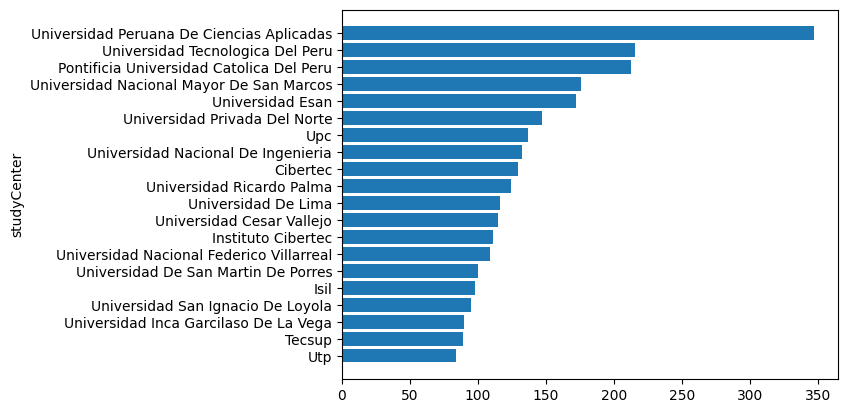

Ing. En Sistemas                  1450
Tecnologias De La Informacion      953
Adm. De Empresas                   645
Ing. Informatica                   373
Ing. Industrial                    308
Computacion / Informatica          263
Otra                               247
Marketing / Comercializacion       238
Recursos Humanos / Relac. Ind.     206
Ing. - Otros                       125
Psicologia                         114
Telecomunicaciones                  90
Ing. Telecomunicaciones             87
Analisis De Sistemas                84
Procesos / Calidad Total            78
Programacion                        74
Trabajo Social                      65
Finanzas                            64
Ing. Electronica                    58
Bachiller                           53
Name: careerField, dtype: int64


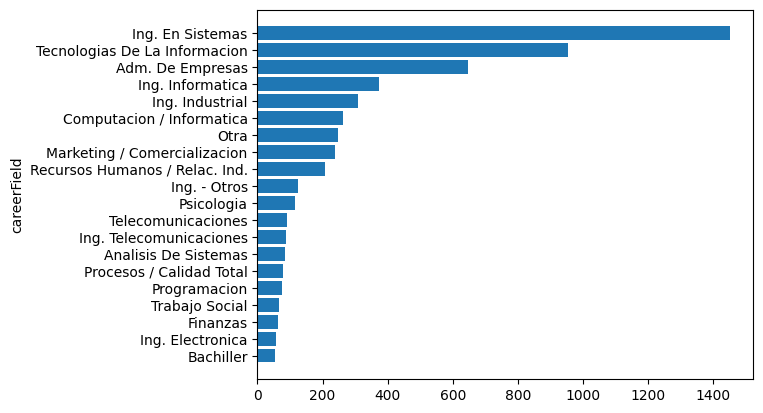

Graduado      4381
En Curso      1761
Abandonado      74
Name: careerStatus, dtype: int64


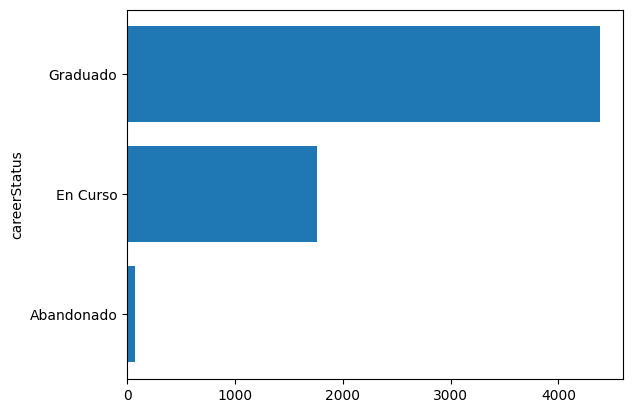

Universitario        2729
Otro                 1624
Posgrado              888
Terciario/Tecnico     509
Master                450
Doctorado              13
Secundario              3
Name: careerDegree, dtype: int64


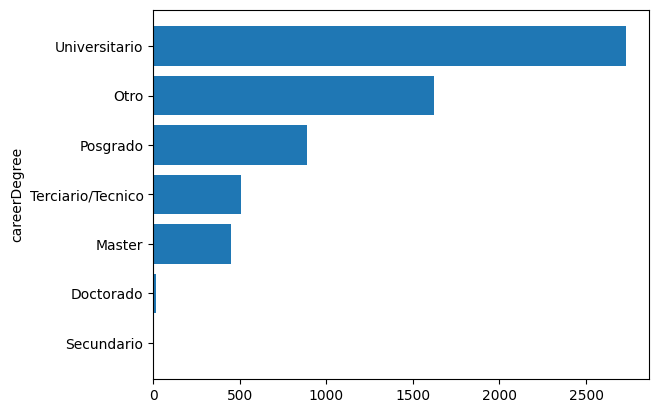

1     1858
2     1414
3      827
4      499
6      335
5      322
7      240
8      149
9      116
11      86
10      80
12      61
14      45
13      36
16      23
15      19
20      18
18      16
17      14
19      14
Name: studiesNumber, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_7956\1267574479.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


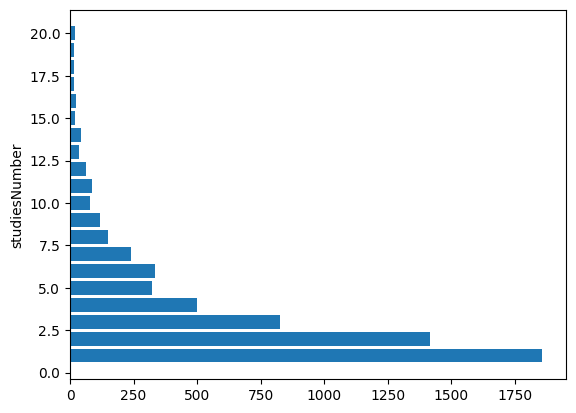

1     664
3     543
2     495
4     429
5     410
6     350
7     336
9     335
8     315
10    255
11    246
13    197
12    197
16    185
14    134
15    113
18     95
17     93
21     77
19     68
Name: technicalSkills, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_7956\1267574479.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


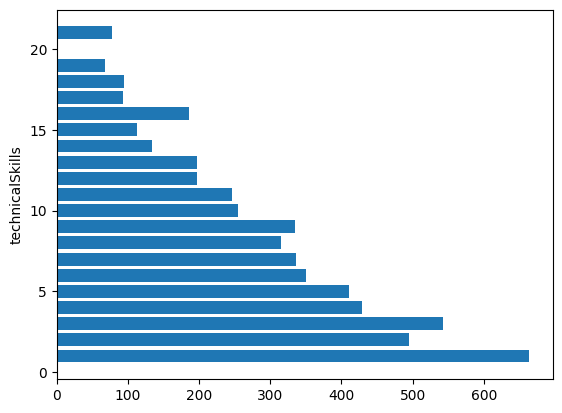

C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_7956\1267574479.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


1    4656
2    1288
3     197
4      51
0      23
5       1
Name: languages, dtype: int64


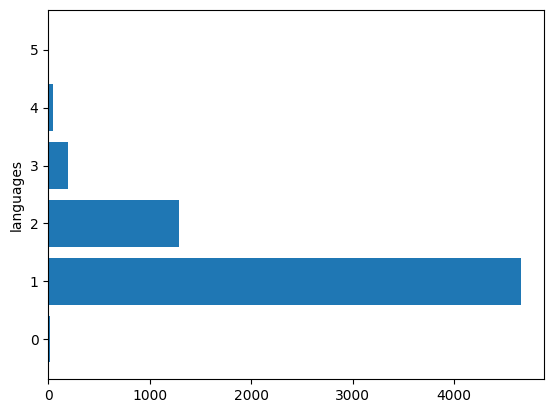

C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_7956\1267574479.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


1     1288
2      904
3      650
4      593
5      536
6      405
7      353
8      291
9      223
10     182
11     147
12     117
13      93
14      69
15      64
17      42
16      35
20      31
19      25
23      22
Name: anotherSkills, dtype: int64


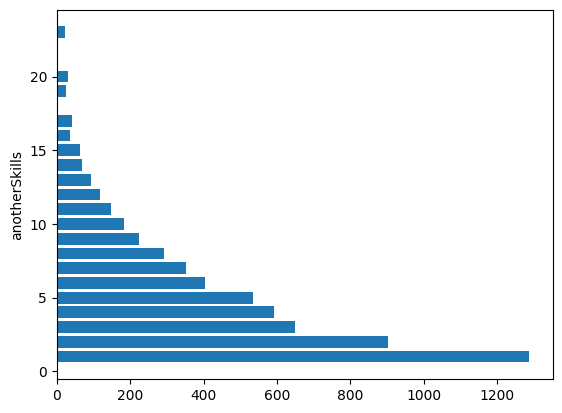

5000     413
2500     391
3500     381
3000     370
4000     369
2000     351
6000     347
4500     291
1500     247
1800     238
5500     220
6500     205
7000     200
1200     158
8000     154
1000     125
1        119
7500     110
10000    102
1025     101
Name: salary, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_7956\1267574479.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


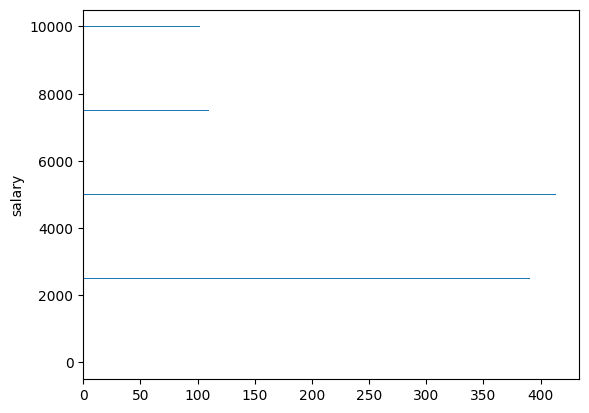

Fin: 2023-05-12 02:52:26.898856
Tiempo: 0:00:01.458077


In [91]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))
  print("Se inició el procesamiento")

  # El dataset principal que sea el de bumeran
  # Los otros archivos que solo se usen para actualizar la variable objetivo
  # Esto porque los otros orígenes están incompletos y costaría llenar los campos (incluso el excel que se hizo)
  isLoadedBumeran = True
  isLoadedLinkedin = True
  isMergedMain = True
  #False

  # Leyendo o calculando bumeran
  bumeranData = readJson(os.path.join(intermFilesFolder, 'bumeran.json')) if isLoadedBumeran else readAndWriteMain('bumeran')
  print("Se terminó de procesar Bumeran")

  # Leyendo o calculando linkedin
  linkedinData = readJson(os.path.join(intermFilesFolder, 'linkedin.json')) if isLoadedLinkedin else readAndWriteMain('linkedin')
  print("Se terminó de procesar Linkedin")

  # Uniendo la data principal (bumeran + linkedin)
  mergedMainData = readJson(os.path.join(mergedMainFolder, 'result.json')) if isMergedMain else readAndWriteMergedMain([bumeranData, linkedinData])
  print("Se terminó de unir la data principal")

  visualizeData(mergedMainData)
  
  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

  #print(counterIn)
  #print(counterOut)

if __name__ == "__main__":
  main()